# Data Exploration

Idea is to look at various datasets for the region of interest (+ presumably wider region as well) to look for interesting patterns (extreme weather events, large-scale weather structures etc)

Rainfall: https://www.sciencedirect.com/science/article/pii/S0022169424012666

In [75]:
## imports
import time
import logging
logging.basicConfig(level='INFO')

import typing

import pandas as pd
import xarray as xr
import numpy as np

import cdsapi
from ecmwf.datastores import Client
import earthkit as ek
import earthkit.data as ekd
import earthkit.plots as ekp

import matplotlib as mpl
import matplotlib.pyplot as plt

REQUEST = False

print('Imports complete')

Imports complete


In [83]:
## constants
# N W S E

SE_CHINA_BBOX = [31.7, 115.0, 23.3, 123.2] ## covers fujian, zhejiang, southmost bit of anhui, bit of taiwan
FZ_BBOX = [26.1, 119.3, 26.1, 119.3]

FZ_SURROUND_BBOX = list(np.array(FZ_BBOX) + [5, -5, -5, 5])

In [190]:
years = [str(yr) for yr in range(1940, 2025)]
months = [[f'{str(i):0>2}' for i in range(1, 13)]]

REQUEST = False

request = {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': ['total_precipitation'],
        'year': years,
        'month': months,
        'time': ['00:00'],
        'data_format': 'netcdf',
        'download_format': 'unarchived',
        'area': FZ_BBOX
}

if REQUEST:
    data = ekd.from_source(
        'cds', 'reanalysis-era5-single-levels-monthly-means', request
    )

    ds = data.to_xarray()
    ds.to_zarr('./FZ_precipitation')
else:
    ds = xr.open_zarr('./FZ_precipitation')

select lat/lon (to reduce from 3D->1D), rename column to time, convert from m to mm

In [191]:
tp = ds.isel(latitude=0, longitude=0).rename({'valid_time':'time'}).tp * 1000

In [215]:
## max precipitation

# tp = tp.isel(time=slice(880, 910, None))

wettest_month_idx = int(tp.argmax())
wettest_month_data = tp.isel(time=wettest_month_idx)

wettest_month = wettest_month_data.time.compute()
max_precip = wettest_month_data.data.compute()

mean_precip = int(tp.mean())
rolling_mean = tp.rolling(time=12).mean()

## trend
x = np.arange(len(tp))
slope, intercept = np.polyfit(x, tp, 1)
trendline = slope * x  + intercept

warming_rate = slope * 120

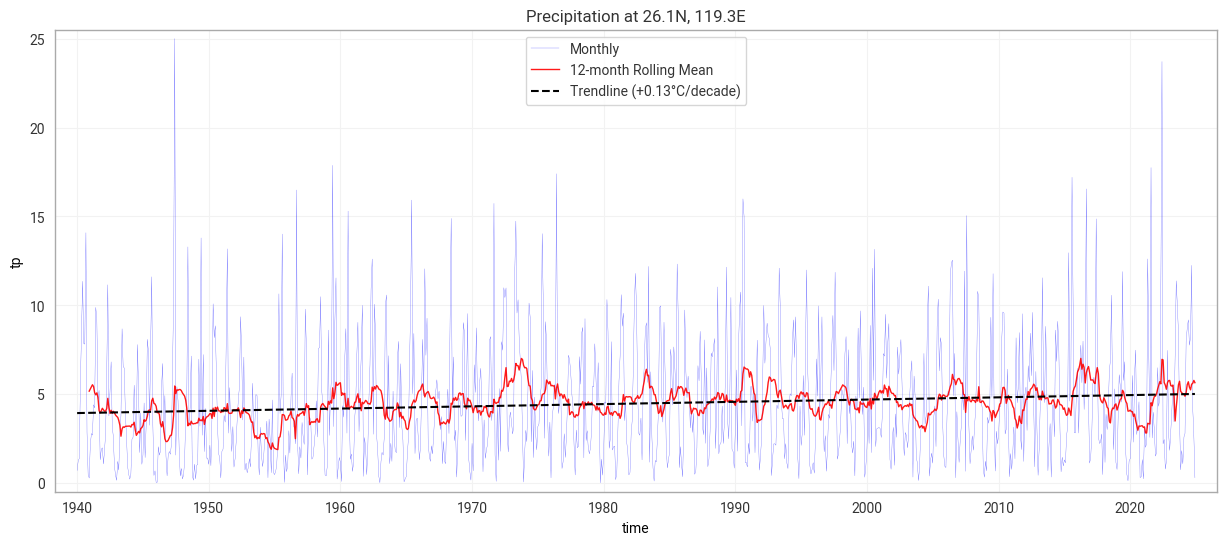

In [220]:
fig, ax = plt.subplots(figsize=(15, 6))

pplot = tp.plot(color='blue', linewidth=0.2, alpha=0.7, label='Monthly', ax=ax)
mplot = rolling_mean.plot(color='red', linewidth=1, alpha=0.9, label='12-month Rolling Mean', ax=ax)
tplot = ax.plot(tp.time.values, trendline, linestyle='dashed', color='black', label=f'Trendline (+{warming_rate:.2f}°C/decade)')

ax.legend()
ax.set_title('Precipitation at 26.1N, 119.3E')

plt.show()

In [84]:
FZ_SURROUND_BBOX

[np.float64(31.1), np.float64(114.3), np.float64(21.1), np.float64(124.3)]

In [ ]:
## FZ TP

years = [str(yr) for yr in range(1940, 2025)]
months = [f'{str(i):0>2}' for i in range(1, 13)]

REQUEST = False

request = {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': ['mean_sea_level_pressure'],
        'year': years,
        'month': months,
        'time': ['00:00'],
        'data_format': 'netcdf',
        'download_format': 'unarchived',
        'area': FZ_SURROUND_BBOX
}

if REQUEST:
    data = ekd.from_source(
        'cds', 'reanalysis-era5-single-levels-monthly-means', request
    )

    ds = data.to_xarray()
    ds.to_zarr('./FZ_area_sl_pressure', mode='w')

else:
    ds = xr.open_zarr('./FZ_area_sl_pressure')

In [ ]:
## TOTAL MSL

years = [str(yr) for yr in range(1940, 2025)]
months = [f'{str(i):0>2}' for i in range(1, 13)]

REQUEST = False

request = {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': ['tp', 'msl'],
        'year': '2022',
        'month': '06',
        'time': ['00:00'],
        'data_format': 'netcdf',
        'download_format': 'unarchived',
        'area': FZ_SURROUND_BBOX
}

if REQUEST:
    data = ekd.from_source(
        'cds', 'reanalysis-era5-single-levels-monthly-means', request
    )

    ds = data.to_xarray()

else:
    ds = xr.open_zarr('./FZ_area_sl_pressure')

In [180]:
## FZ AREA ALL

mag = 10
FZ_AREA_BBOX = list(np.array(FZ_BBOX) + np.array([1, -1, -2, 2])*5)

years = [1947]
months = [f'{str(i):0>2}' for i in range(1, 13)]

REQUEST = True

request = {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': ['tp', 'msl'],
        'year': '2022',
        'month': '06',
        'time': ['00:00'],
        'data_format': 'netcdf',
        'download_format': 'unarchived',
        'area': FZ_AREA_BBOX
}

if REQUEST:
    data = ekd.from_source(
        'cds', 'reanalysis-era5-single-levels-monthly-means', request
    )

    ds = data.to_xarray()

else:
    ds = xr.open_zarr('./FZ_area_sl_pressure')

2026-02-03 10:33:55,415 INFO Request ID is d1beb6b3-bee1-4fc4-93d1-d1081993fa40
INFO:ecmwf.datastores.legacy_client:Request ID is d1beb6b3-bee1-4fc4-93d1-d1081993fa40
2026-02-03 10:33:55,719 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2026-02-03 10:34:04,137 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2026-02-03 10:34:17,427 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-cache-2/2026-02-03/b2be24ca5522c898214b35036437c62e.zip


In [183]:
ds.compute()

<xarray.Dataset> Size: 61kB
Dimensions:     (valid_time: 2, latitude: 61, longitude: 61)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 16B 2022-06-01 2022-06-01T06:00:00
  * latitude    (latitude) float64 488B 31.1 30.85 30.6 ... 16.6 16.35 16.1
  * longitude   (longitude) float64 488B 114.3 114.5 114.8 ... 128.8 129.1 129.3
    number      int64 8B 0
    expver      <U4 16B '0001'
Data variables:
    tp          (valid_time, latitude, longitude) float32 30kB nan ... 0.008942
    msl         (valid_time, latitude, longitude) float32 30kB 1.003e+05 ... nan
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-02-03T10:34 GRIB to CDM+CF via cfgrib-0.9.1...

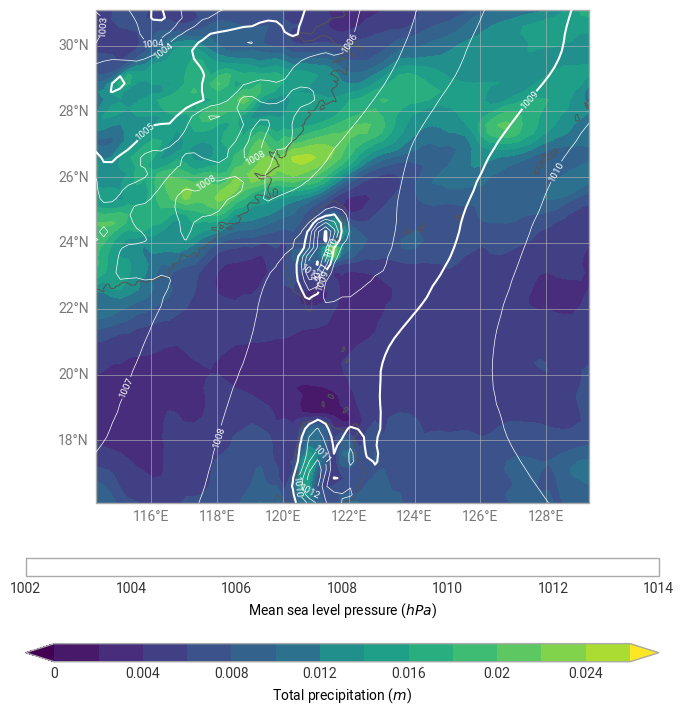

In [188]:
pressure_style = ekp.styles.Contour(
    units="hPa",
    labels=True,
    linewidths=np.array([0.25, 0.25, 0.25, 0.75])*2,
    linecolors='white'
)

precip_style = ekp.styles.Style(
    colors='viridis',
    extend='both'
)

chart = ekp.Map()

chart.quickplot(ds.isel(valid_time=-1).compute().tp, style=precip_style)
chart.quickplot(ds.isel(valid_time=0).compute().msl, style=pressure_style)

chart.coastlines()
chart.borders()
chart.gridlines()

chart.legend()
chart.show()